# ANOVA - Aplicação no Mercado Financeiro

### Mestrado Profissional em Computação Aplicada - Universidade de Brasília

**Aluno**: Thiago Viana Fernandes  
**Curso**: AEDI 1/2022  
Prof. João Gabriel de Moraes Souza  

## Importando as Bibliotecas

In [1]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
from scipy import optimize
from scipy.stats import levene, bartlett, f, norm, f_oneway

## Construindo uma Base de Dados Financeiros

A fim de ter maior dinamismo, busquei FIIs sugeridos na carteira de agosto de 2022 pelo BTG Pactual. Para fins de comparação, tentei usar o Índice de Fundos de Investimentos Imobiliários (IFIX). No entanto, estava sendo retornado inúmeros valores nulos o que prejudicaria as comparações. Dessa forma, optei por fazer comparação da carteira com o próprio IBOV mesmo. 

In [2]:
fiis = ['BTCR11.SA', 
       'RBRR11.SA', 
       'KNCR11.SA',
       'HGCR11.SA', 
       'VILG11.SA', 
       'BRCO11.SA', 
       'RBRP11.SA', 
       'BRCR11.SA', 
       'RCRB11.SA',
       'HGRE11.SA', 
       '^BVSP']
fiis

['BTCR11.SA',
 'RBRR11.SA',
 'KNCR11.SA',
 'HGCR11.SA',
 'VILG11.SA',
 'BRCO11.SA',
 'RBRP11.SA',
 'BRCR11.SA',
 'RCRB11.SA',
 'HGRE11.SA',
 '^BVSP']

### Dados de 2022

In [3]:
fiis_df = pd.DataFrame()
for fii in fiis:
    fiis_df[fii] = data.DataReader(fii, data_source='yahoo', start='2022-01-01')['Close']

fiis_df.reset_index(inplace=True)
fiis_df

,Date,BTCR11.SA,RBRR11.SA,KNCR11.SA,HGCR11.SA,VILG11.SA,BRCO11.SA,RBRP11.SA,BRCR11.SA,RCRB11.SA,HGRE11.SA,^BVSP
0,2022-01-03,89.650002,99.000000,102.500000,105.699997,97.180000,101.540001,77.000000,72.599998,136.789993,133.919998,103922.000000
1,2022-01-04,90.230003,98.980003,101.570000,105.400002,98.300003,104.500000,73.769997,71.540001,134.210007,134.899994,103514.000000
2,2022-01-05,90.910004,98.500000,101.300003,104.790001,94.160004,99.010002,72.900002,70.699997,132.740005,134.100006,101006.000000
3,2022-01-06,92.000000,99.209999,101.160004,105.000000,96.550003,99.000000,71.930000,71.849998,130.210007,130.009995,101561.000000
4,2022-01-07,92.809998,99.040001,101.050003,105.470001,97.930000,99.800003,71.059998,71.400002,127.000000,132.750000,102719.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
146,2022-08-02,95.500000,98.160004,101.120003,102.809998,93.510002,99.919998,53.990002,58.380001,121.529999,124.169998,103362.000000
147,2022-08-03,96.150002,98.209999,100.830002,102.970001,94.000000,99.360001,54.259998,57.560001,121.820000,123.879997,103775.000000
148,2022-08-04,97.000000,98.559998,101.750000,102.930000,94.349998,100.000000,54.000000,57.770000,122.550003,124.500000,105892.000000
149,2022-08-05,97.529999,98.209999,101.269997,103.059998,94.209999,99.760002,54.639999,58.000000,123.849998,126.290001,106472.000000


###  Log-retorno 

In [4]:
numero_de_fiis = len(fiis) - 1 # número de FIIs diferentes da carteira, excluíndo-se o IBOV.
data_negociacao_df = fiis_df.Date
fiis_dia_df = fiis_df.iloc[:,1:numero_de_fiis + 2] # retorna todas as colunas com exceção da data.
fiis_shift_dia_df = fiis_dia_df.copy().shift(1)
log_retorno_df = np.log(fiis_dia_df / fiis_shift_dia_df)
carteira_df = log_retorno_df.iloc[:,0:numero_de_fiis].sum(axis="columns") / numero_de_fiis # calcula a média das colunas, com exceção da coluna "Data" e "IFIX"
carteira_df.name = "CARTEIRA"
ibov_df = log_retorno_df["^BVSP"].fillna(0) # preenche todos os valores nulos com 0
analise_df = pd.concat([data_negociacao_df, carteira_df, ibov_df], axis=1)
analise_df

,Date,CARTEIRA,^BVSP
0,2022-01-03,0.000000,0.000000
1,2022-01-04,-0.003483,-0.003934
2,2022-01-05,-0.014345,-0.024527
3,2022-01-06,-0.000279,0.005480
4,2022-01-07,0.001011,0.011338
...,...,...,...
146,2022-08-02,0.009266,0.011061
147,2022-08-03,-0.000353,0.003988
148,2022-08-04,0.004100,0.020195
149,2022-08-05,0.003512,0.005462


### Visualização das Distribuições 

#### Referente à carteira

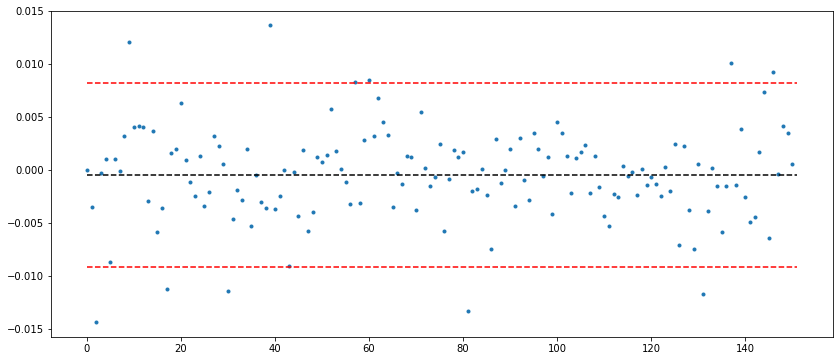

In [5]:
desvio_padrao = analise_df["CARTEIRA"].std()
media = analise_df["CARTEIRA"].mean()

intervalo = norm.interval(alpha=0.95, loc=media, scale=desvio_padrao)
ax = analise_df["CARTEIRA"].plot(style = ".")
ax.figure.set_size_inches(14, 6)
ax.hlines(y=media, xmin = 0, xmax = len(analise_df["CARTEIRA"]), colors="black", linestyles="dashed")
ax.hlines(y=intervalo[0], xmin = 0, xmax = len(analise_df["CARTEIRA"]), colors="red", linestyles="dashed")
ax.hlines(y=intervalo[1], xmin = 0, xmax = len(analise_df["CARTEIRA"]), colors="red", linestyles="dashed")

#### Referente ao IBOV

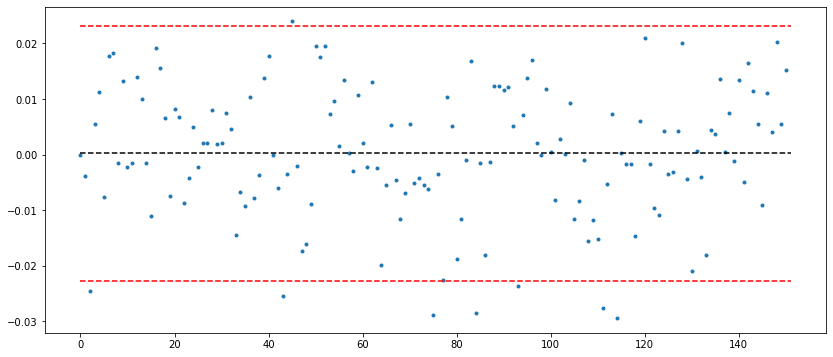

In [8]:
desvio_padrao = analise_df["^BVSP"].std()
media = analise_df["^BVSP"].mean()

intervalo = norm.interval(alpha=0.95, loc=media, scale=desvio_padrao)
ax = analise_df["^BVSP"].plot(style=".")
ax.figure.set_size_inches(14, 6)
ax.hlines(y=media, xmin=0, xmax=len(analise_df["^BVSP"]), colors="black", linestyles="dashed")
ax.hlines(y=intervalo[0], xmin=0, xmax=len(analise_df["^BVSP"]), colors="red", linestyles="dashed")
ax.hlines(y=intervalo[1], xmin=0, xmax=len(analise_df["^BVSP"]), colors="red", linestyles="dashed")

In [11]:
significancia = 0.05
tamanho_amostra = 100

amostra_1_carteira = analise_df["CARTEIRA"].sample(n=tamanho_amostra, random_state=5)
amostra_2_carteira = analise_df["CARTEIRA"].sample(n=tamanho_amostra, random_state=4)
amostra_3_carteira = analise_df["CARTEIRA"].sample(n=tamanho_amostra, random_state=3)

amostra_1_ibovespa = analise_df["^BVSP"].sample(n=tamanho_amostra, random_state=5)
amostra_2_ibovespa = analise_df["^BVSP"].sample(n=tamanho_amostra, random_state=4)
amostra_3_ibovespa = analise_df["^BVSP"].sample(n=tamanho_amostra, random_state=3)

### Teste de Levene  
  
  "Em estatística, o teste de Levene é uma estatística inferencial usada para avaliar a igualdade de variâncias de uma variável calculada para dois ou mais grupos. Alguns procedimentos estatísticos comuns presumem que as variâncias das populações das quais as diferentes amostras são extraídas são iguais." (Wikipedia)

In [15]:
stat_teste, p_valor = levene(amostra_1_carteira, amostra_2_carteira, amostra_3_carteira)
print(f"Estatística-teste: {stat_teste}")
print(f"P-valor: {p_valor}")

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")

Estatística-teste: 0.12910871114803904
P-valor: 0.8789277161379128
Não há perturbação aleatória.


In [16]:
stat_teste, p_valor = levene(amostra_1_ibovespa, amostra_2_ibovespa, amostra_3_ibovespa)
print(f"Estatística-teste: {stat_teste}")
print(f"P-valor: {p_valor}")

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")



Estatística-teste: 0.37637497149633636
P-valor: 0.6866718121199802
Não há perturbação aleatória.


Como resultado, não "Não há perturbação aleatória", podemos concluir que o “ruído” ou perturbação aleatória na relação entre as variáveis independentes e a variável dependente é o mesmo em todos os valores das variáveis independentes, para os casos da carteira e para os casos do ibov.

### Teste de Bartlett

In [17]:
stat_teste, p_valor = bartlett(amostra_1_carteira, amostra_2_carteira, amostra_3_carteira)
print(f"Estatística-teste: {stat_teste:0.4f}")
print(f"P-valor: {p_valor:0.4f}")

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")

Estatística-teste: 0.5792
P-valor: 0.7486
Não há perturbação aleatória.


In [18]:
stat_teste, p_valor = bartlett(amostra_1_ibovespa, amostra_2_ibovespa, amostra_3_ibovespa)
print(f"Estatística-teste: {stat_teste:0.4f}")
print(f"P-valor: {p_valor:0.4f}")

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")

Estatística-teste: 0.4037
P-valor: 0.8172
Não há perturbação aleatória.


Como resultado, não "Não há perturbação aleatória", de forma semelhante ao Teste de Leneve, podemos concluir que a perturbação aleatória na relação entre as variáveis independentes e a variável dependente é o mesmo em todos os valores das variáveis independentes, para os casos da carteira e para os casos do ibov.

## ANOVA

Como visto em sala, sabemos que os erros possuem variância comum. Para detectar isso, realizaremos os testes de Levene e Bartlett. Considerando os seguintes pressupostos:
- Normalidade;
- Variâncias Iguais;
- Independência.

Onde:
H0: μ1=μ2=μ3=...=μn

H1: nem todas as médias de taxa de retorno são iguais.

In [7]:
analise_df_melted = pd.melt(analise_df, id_vars=["Date"], value_vars=["CARTEIRA", "^BVSP"])
analise_df_melted.columns = ["Date", "Tipo", "Taxa de Retorno"]
analise_df_melted

,Date,Tipo,Taxa de Retorno
0,2022-01-03,CARTEIRA,0.000000
1,2022-01-04,CARTEIRA,-0.003483
2,2022-01-05,CARTEIRA,-0.014345
3,2022-01-06,CARTEIRA,-0.000279
4,2022-01-07,CARTEIRA,0.001011
...,...,...,...
297,2022-08-02,^BVSP,0.011061
298,2022-08-03,^BVSP,0.003988
299,2022-08-04,^BVSP,0.020195
300,2022-08-05,^BVSP,0.005462


In [20]:
# Create ANOVA backbone table
data = [
    ["Entre grupos", "", "", "", "", "", ""], 
    ["Dentro dos grupos", "", "", "", "", "", ""], 
    ["Total", "", "", "", "", "", ""]
]
anova_table = pd.DataFrame(data, columns = ["Fonte da Variação", "SS", "df", "MS", "F", "P-value", "F crit"])
anova_table.set_index("Fonte da Variação", inplace = True)

# calculate SSTR and update anova table
x_bar = analise_df_melted["Taxa de Retorno"].mean()
SSTR = analise_df_melted.groupby("Tipo").count() * (analise_df_melted.groupby("Tipo").mean() - x_bar)**2
anova_table["SS"]["Entre grupos"] = SSTR["Taxa de Retorno"].sum()

# calculate SSE and update anova table
SSE = (analise_df_melted.groupby("Tipo").count() - 1) * analise_df_melted.groupby("Tipo").std()**2
anova_table["SS"]["Dentro dos grupos"] = SSE["Taxa de Retorno"].sum()

# calculate SSTR and update anova table
SSTR = SSTR["Taxa de Retorno"].sum() + SSE["Taxa de Retorno"].sum()
anova_table["SS"]["Total"] = SSTR

# update degree of freedom
anova_table["df"]["Entre grupos"] = analise_df_melted["Tipo"].nunique() - 1
anova_table["df"]["Dentro dos grupos"] = analise_df_melted.shape[0] - analise_df_melted["Tipo"].nunique()
anova_table["df"]["Total"] = analise_df_melted.shape[0] - 1

# calculate MS
anova_table["MS"] = anova_table["SS"] / anova_table["df"]

# calculate F
F = anova_table["MS"]["Entre grupos"] / anova_table["MS"]["Dentro dos grupos"]
anova_table["F"]["Entre grupos"] = F

# p-value
anova_table["P-value"]["Entre grupos"] = 1 - f.cdf(F, anova_table["df"]["Entre grupos"], anova_table["df"]["Dentro dos grupos"])

# F critical
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table["F crit"]["Entre grupos"] = f.ppf(1-alpha, anova_table["df"]["Entre grupos"], anova_table["df"]["Dentro dos grupos"])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Fonte da Variação,,,,,,
Entre grupos,0.000042,1,0.000042,0.535483,0.464882,5.074698
Dentro dos grupos,0.02348,300,0.000078,,,
Total,0.023522,301,0.000078,,,


In [21]:
stat_teste, p_valor = f_oneway(analise_df["CARTEIRA"], analise_df["^BVSP"])

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")



Não há perturbação aleatória.


## Conclusão  
  
  Não podemos rejeitar a hipótese de que as médias das taxas de retorno da Carteira são iguais às médias das taxas de retorno do índice IBOVESPA. 